# Clothing Image Classifier 2
This notbook I build a clothing image classifier using A **fully connected nueral network** wih 2 *fully connected layers* and the FashionMNIST dataset

# Define Transform 

In [42]:
import torchvision.transforms as transforms 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalize 
])

# Data & Data Loaders

In [46]:
import torchvision
import torch

#datasets 
trainset = torchvision.datasets.FashionMNIST(root='./data', download=True, 
                                             train=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', download=True,
                                            train=False, transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, 
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                         shuffle=False, num_workers=2)

In [47]:
# classes 
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Check DataLoader Output

Sandal


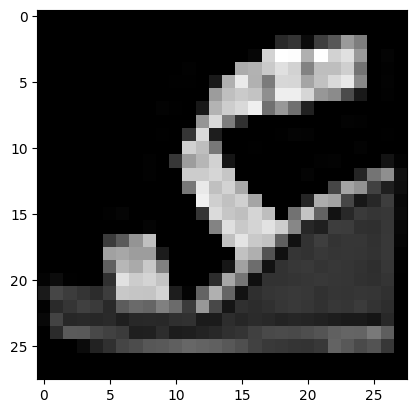

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# show img function 
# PyToch sees images as (Channel, Height, Width), but numpy sees them as (Height, width, Channel)
# Function is needed to make he switch 
def imshow(img):
    img = img / 2 + 0.5     # unormalize
    npimg = img.numpy()     #
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose the tensor in order to match the expected shape

# get image batch from trainset 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show the image
imshow(torchvision.utils.make_grid(images))
print(' | '.join(f'{classes[labels[i]]}' for i in range(len(labels))))

## Create Model 

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class FCN2(nn.Module):
    def __init__(self):
        super(FCN2, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        
        # Flatten 
        x = x.view(-1, 28 * 28)
        
        # Run through decision layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 


In [50]:
fcn2 = FCN2()

## Loss function and Back Prop 

In [51]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn2.parameters(), lr=0.1, momentum=0)

## Train Model 

In [52]:
for epoch in range(20):
    running_loss = 0.0
    print_interval = 400
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        # forward
        outputs = fcn2(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        
        # back prop
        loss.backward()
        # update weights
        optimizer.step()

        # stats 
        running_loss += loss.item()
        if i % print_interval == print_interval - 1:
            avg_loss = running_loss / print_interval
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] loss: {avg_loss:.3f}')
            running_loss = 0.0 
print('finished training')

[Epoch 1, Batch   400] loss: 2.523
[Epoch 1, Batch   800] loss: 2.510
[Epoch 1, Batch  1200] loss: nan
[Epoch 1, Batch  1600] loss: nan
[Epoch 1, Batch  2000] loss: nan
[Epoch 1, Batch  2400] loss: nan
[Epoch 1, Batch  2800] loss: nan
[Epoch 1, Batch  3200] loss: nan
[Epoch 1, Batch  3600] loss: nan
[Epoch 1, Batch  4000] loss: nan
[Epoch 1, Batch  4400] loss: nan
[Epoch 1, Batch  4800] loss: nan
[Epoch 1, Batch  5200] loss: nan
[Epoch 1, Batch  5600] loss: nan
[Epoch 1, Batch  6000] loss: nan
[Epoch 1, Batch  6400] loss: nan
[Epoch 1, Batch  6800] loss: nan
[Epoch 1, Batch  7200] loss: nan


libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x109443f70>
Traceback (most recent call last):
  File "/Users/joelgc/2026/deeplearn440/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/Users/joelgc/2026/deeplearn440/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    re

KeyboardInterrupt: 

## Test Model 

In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        
        images, labels = data
        
        # raw model scores
        outputs = fcn2(images)
        # extract highest score
        _, predicted = torch.max(outputs.data, 1)
        # count total images processes so far
        total += labels.size(0)
        # count how many in this batch matches the labels
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total 
print(f'Final accuracy on {total} test images: {accuracy:.1f}%')

Final accuracy on 10000 test images: 66.7%
